In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader

from datasets_gen import get_mnist_
from noise_scheduler import noise_scheduler
import unet

In [4]:
Device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
im_data=get_mnist_(normalize=True)
im_data = F.pad(im_data, (1, 2, 1, 2), mode='constant', value=-1)
im_data=im_data.unsqueeze(1)
im_tensor=TensorDataset(im_data,im_data)
trainloader= DataLoader(im_tensor,batch_size=64,shuffle=True)

In [6]:
model=unet.Unet(1,8)
model=model.to(Device)
optim=torch.optim.Adam(model.parameters(),lr=0.001)
criterion=F.mse_loss

In [7]:
# Set the number of epochs
num_epochs = 100
loss_list=[]

for epoch in range(num_epochs):
    count=0
    total_loss=0
    for images,_ in trainloader:
        images = images.to(Device)
        b,f,c,c=images.shape
        t=random.randint(0, 1000)
        noise=torch.randn(b,f,c,c).to(Device)

        noised_image = noise_scheduler(images,noise,t)
        pred_noise=model(noised_image)
        loss = criterion(pred_noise,noise)

        count+=1
        total_loss+=loss.item()

        loss.backward(retain_graph=True)
        optim.step()
        optim.zero_grad()

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg_Loss: {total_loss/count:.4f}, Sum_loss:{total_loss:.4f}")


#torch.save(model.state_dict(), 'unet_model.pth')


Epoch [1/100], Avg_Loss: 0.0706, Sum_loss:66.2366
Epoch [2/100], Avg_Loss: 0.0250, Sum_loss:23.4064
Epoch [3/100], Avg_Loss: 0.0193, Sum_loss:18.0862
Epoch [4/100], Avg_Loss: 0.0179, Sum_loss:16.7913


KeyboardInterrupt: 

In [26]:
def DDIM_sampler(model,at=0.99,ts=650):
    with torch.no_grad():
        model.eval()
        image=torch.randn(64,1,31,31).to(Device)
        for t in range(1,ts):
            noise=torch.randn(64,1,31,31).to(Device)
            pred_noise=model(image,ts-t)
            #pred_noise_t1=model(image,ts-t-1)
            vart=math.sqrt(1-math.pow(at,ts-t))
            vart1=math.sqrt(1-math.pow(at,ts-t))
            alpha=(1-at)/vart
            if t < 3*ts//4:
              image=(image-alpha*pred_noise)/math.sqrt(at) 
            else:
              image=(image-alpha*pred_noise)/math.sqrt(at)
    return image


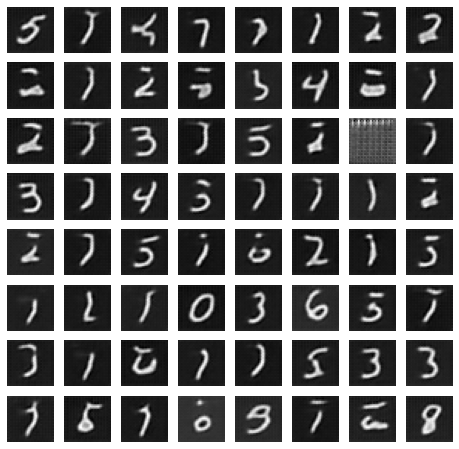

In [27]:
im=DDIM_sampler(model,ts=500)
x=im[:64]
x = x[:64].view(8, 8, 31, 31)
x = x.to('cpu')
image_np = x.numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels
plt.savefig('samples.jpeg')
plt.show()

In [ ]:
im=torch.randn(64,1,31,31).to(Device)
for i in range(50):
  t=10*(50-i)
  noise=torch.randn(64,1,31,31).to(Device)
  at=math.pow(0.99,t-1)
  att=math.pow(0.99,t)
  im=((im-math.sqrt(1-at)*pred_noise)/math.sqrt(at))


x=im[:64]
x = x[:64].view(8, 8, 31, 31)
x = x.to('cpu')
image_np = x.detach().numpy()
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels
plt.show()


In [ ]:
x[0]

In [ ]:
im=im_data[:64]
t=1
noise=torch.randn(64,1,31,31)
im=noise_scheduler(im,noise,t)
#im=im.to(Device)
#pred_noise=model(im)
#at=at=math.pow(0.99,t)
#im=(im-math.sqrt(1-at)*pred_noise)/math.sqrt(at)

x=im[:64]
x = x[:64].view(8, 8, 31, 31)
x = x.to('cpu')
image_np = x.detach().numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels
plt.show()

In [ ]:
im=im_data[:64]

noise=torch.randn(64,1,31,31)
t=500
im=noise_scheduler(im,noise,t)
im=im.to(Device)
pred_noise=model(im)
at=at=math.pow(0.99,t)
im=(im-math.sqrt(1-at)*pred_noise)/math.sqrt(at)

x=im[:64]
x = x[:64].view(8, 8, 31, 31)
x = x.to('cpu')
image_np = x.detach().numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels
plt.show()

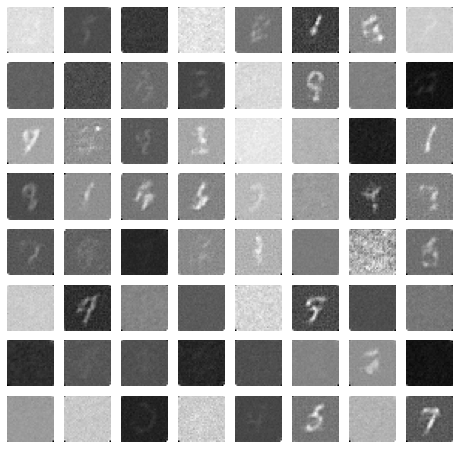

In [9]:
im=torch.randn(64,1,31,31).to(Device)
for i in range(20):
  t=(20-i)*20
  pred_noise=model(im)
  noise=torch.randn(64,1,31,31).to(Device)
  at=math.pow(0.99,t-1)
  att=math.pow(0.99,t)
  im=((im-math.sqrt(1-at)*pred_noise)/math.sqrt(at)) + math.sqrt(1-at)*noise

x=im[:64]
x = x[:64].view(8, 8, 31, 31)
x = x.to('cpu')
image_np = x.detach().numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels
plt.show()

